# Temperature extremes

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1980-01-01'
end_date = '1989-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [6]:
def read_data(infile, regrid=False, time_bounds=None):
    """Read data and calculate annual mean.
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile, decode_timedelta=False)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

In [7]:
def plot_index(var_name, index_name, data_levels, diff_levels, agcd_file, parent_file, downscaled_file):
    """Plot a climate index"""

    index_name_lower = index_name.lower()
    infiles = {}
    infiles['AGCD'] = agcd_file
    infiles['ACCESS-CM2'] = parent_file
    infiles['BARPA'] = downscaled_file
    
    annual_mean = {}
    annual_mean['AGCD'] = read_data(
        infiles['AGCD'], regrid=False, time_bounds=[start_date, end_date]
    )

    for model in ['ACCESS-CM2', 'BARPA']:
        annual_mean[model] = read_data(
            infiles[model], regrid=annual_mean['AGCD'], time_bounds=[start_date, end_date]
        )

    plotting.compare_agcd_gcm_rcm(
        annual_mean['AGCD'][index_name],
        annual_mean['ACCESS-CM2'][index_name],
        var_name,
        index_name_lower,
        'ACCESS-CM2',
        'BARPA',
        start_date,
        end_date,
        data_levels,
        diff_levels,
        rcm_da=annual_mean['BARPA'][index_name],
)

## TXx - Maximum daily maximum temperature

/g/data/xv83/dbi599/model-evaluation/tasmax_txx_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


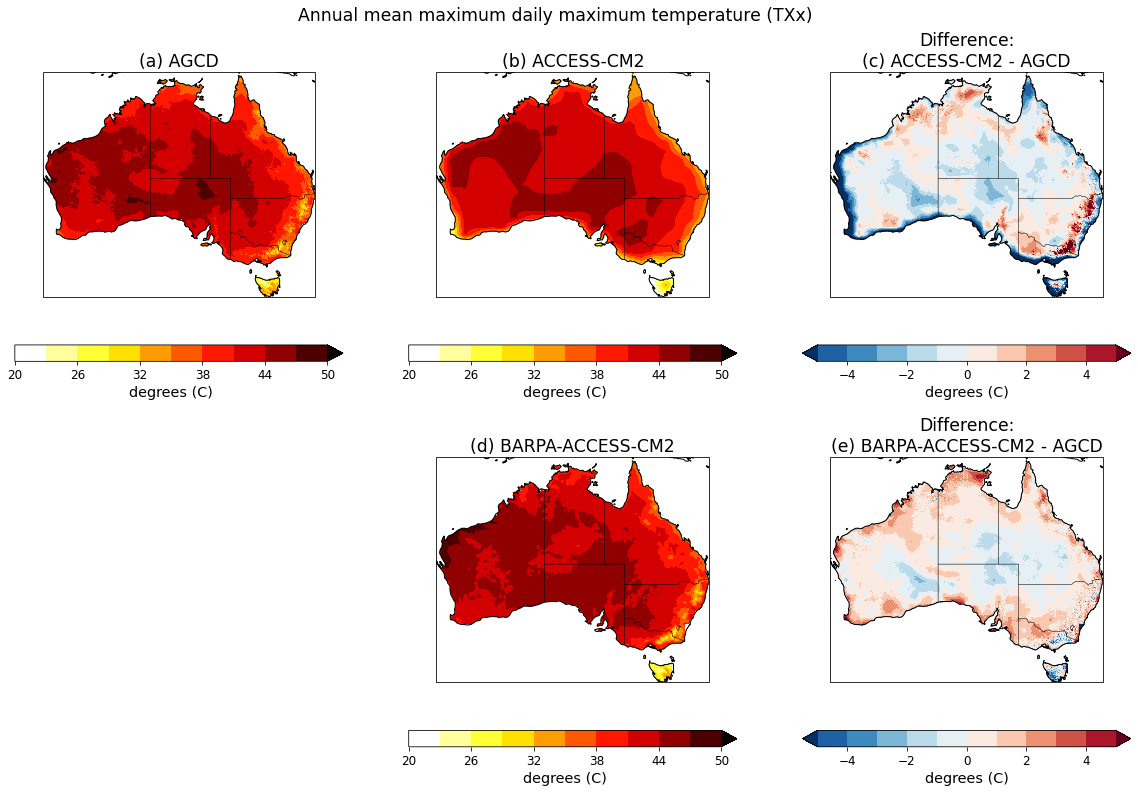

In [8]:
plot_index(
    'tasmax',
    'TXx',
    [20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    '/g/data/xv83/dbi599/indices/txx_year_AGCD_v1_r005_1910-2021.nc',
    '/g/data/xv83/dbi599/indices/txx_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc',
    '/g/data/xv83/dbi599/indices/txx_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc',
)

## TXn - Minimum daily maximum temperature

/g/data/xv83/dbi599/model-evaluation/tasmax_txn_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


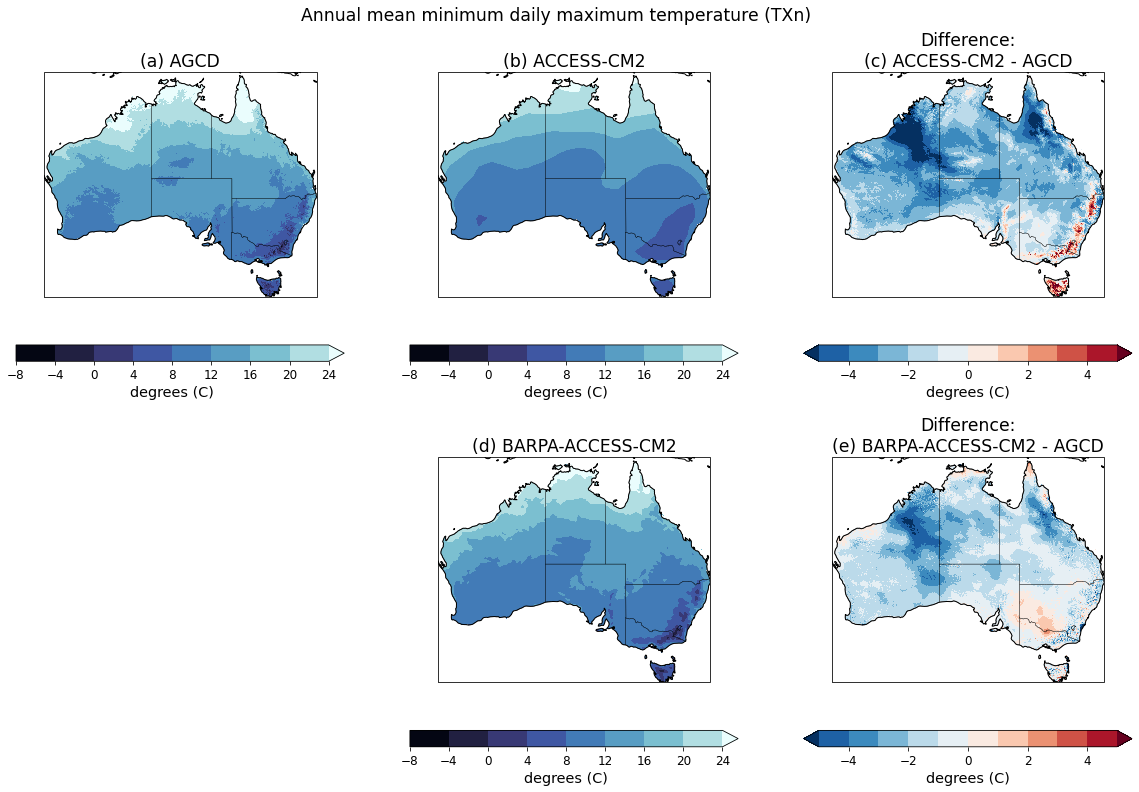

In [9]:
plot_index(
    'tasmax',
    'TXn',
    [-8, -4, 0, 4, 8, 12, 16, 20, 24],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    '/g/data/xv83/dbi599/indices/txn_year_AGCD_v1_r005_1910-2021.nc',
    '/g/data/xv83/dbi599/indices/txn_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc',
    '/g/data/xv83/dbi599/indices/txn_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc',
)

## WSDI - Warm spell duration index

Annual count of days with at least six consecutive days where Tmax > 90th percentile. 

TODO: See if I get the same result from calculating ACCESS-CM2 just for 1980-1989.

/g/data/xv83/dbi599/model-evaluation/tasmax_wsdi_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


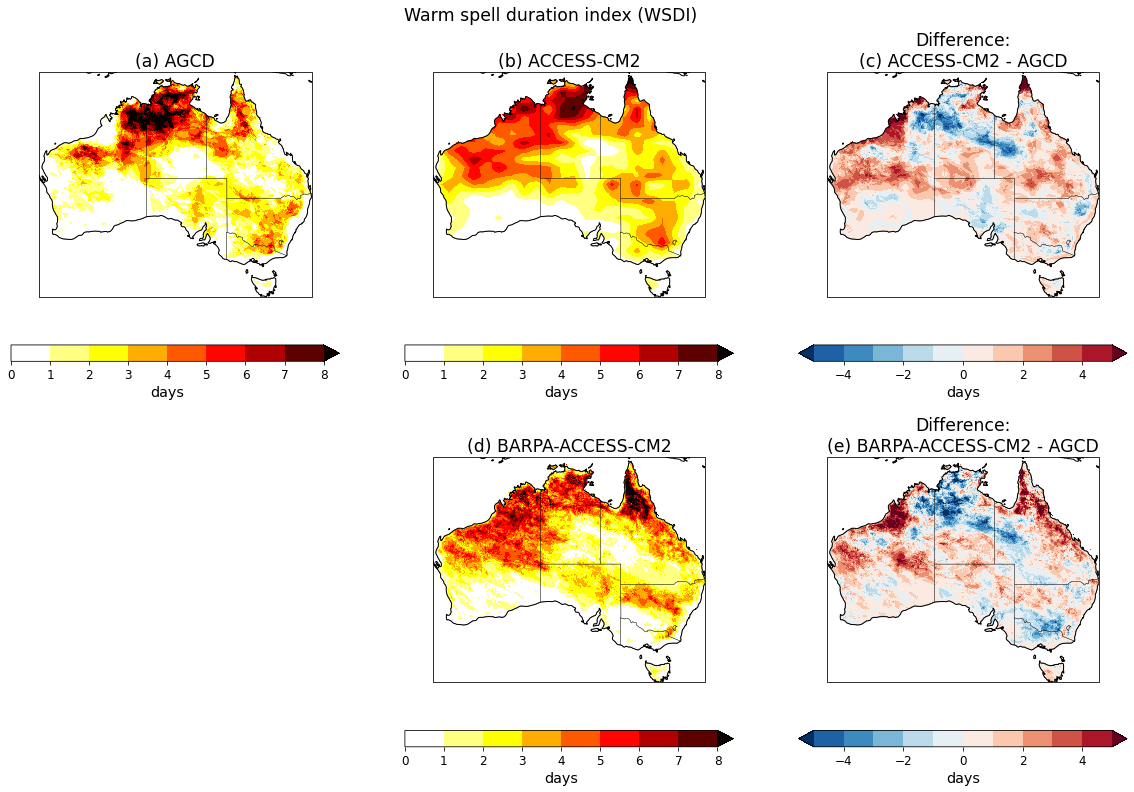

In [18]:
plot_index(
    'tasmax',
    'WSDI',
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    '/g/data/xv83/dbi599/indices/wsdi_year_AGCD_v1_r005_1980-1989.nc',
    '/g/data/xv83/dbi599/indices/wsdi_year_ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
    '/g/data/xv83/dbi599/indices/wsdi_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
)

## CSDI - Cold spell duration index

Annual count of days with at least six consecutive days where Tmin < 10th percentile.

/g/data/xv83/dbi599/model-evaluation/tasmin_csdi_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


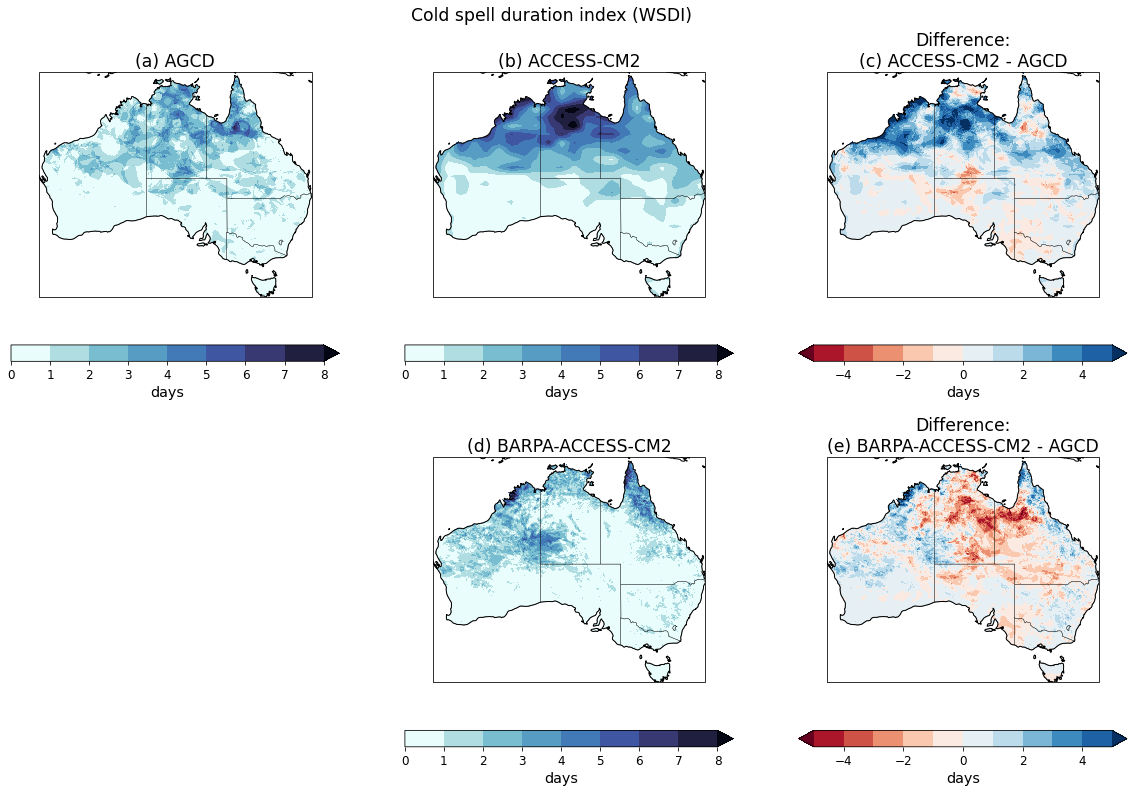

In [20]:
plot_index(
    'tasmin',
    'CSDI',
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    '/g/data/xv83/dbi599/indices/csdi_year_AGCD_v1_r005_1980-1989.nc',
    '/g/data/xv83/dbi599/indices/csdi_year_ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
    '/g/data/xv83/dbi599/indices/csdi_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
)

TODO: When I set the base period to 1980-1989 but calculated WSDI and CSDI for the entire 1850-2014 period for ACCESS-CM2 I got different results to when I just calculated for the 1980-1989 period. Need to figure out why, because they should be the same.

## FD - Frost days

Annual count of number of days where Tmin < 0C.

/g/data/xv83/dbi599/model-evaluation/tasmin_fd_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


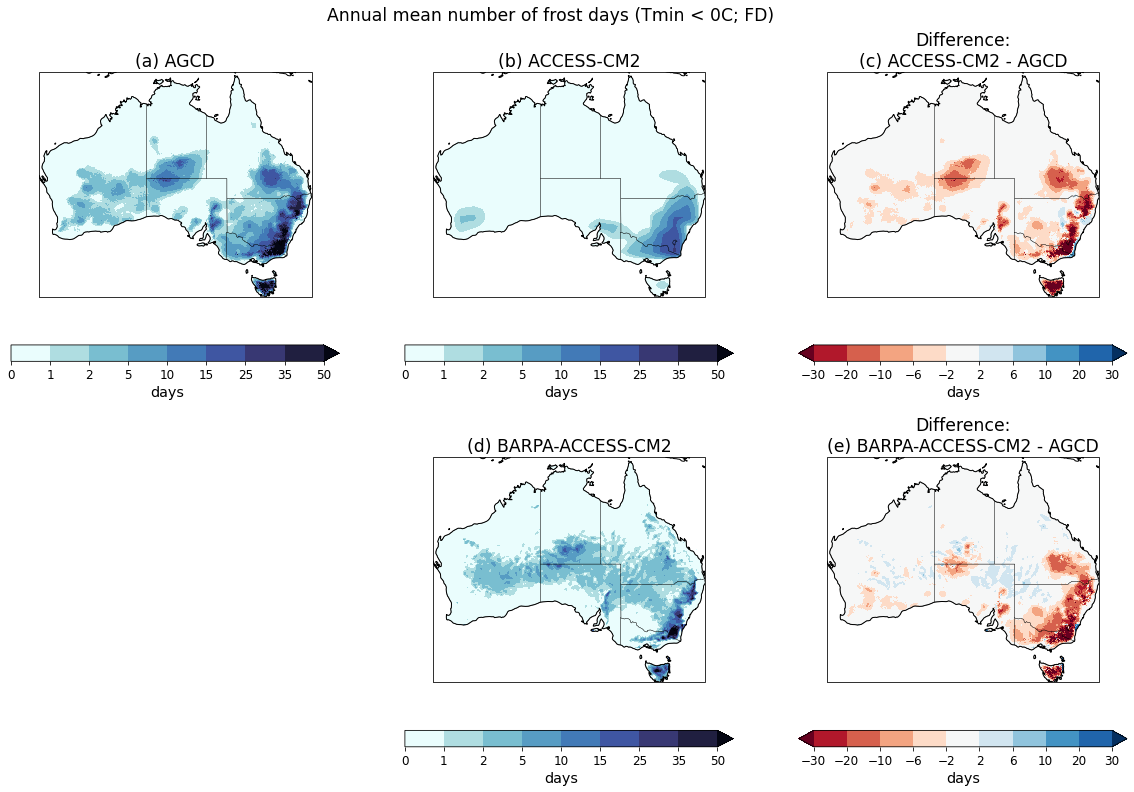

In [15]:
plot_index(
    'tasmin',
    'FD',
    [0, 1, 2, 5, 10, 15, 25, 35, 50],
    [-30, -20, -10, -6, -2, 2, 6, 10, 20, 30],
    '/g/data/xv83/dbi599/indices/fd_year_AGCD_v1_r005_1910-2021.nc',
    '/g/data/xv83/dbi599/indices/fd_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc',
    '/g/data/xv83/dbi599/indices/fd_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
)

## TR - Tropical nights

Number of tropical nights (Tmin > 20C)

/g/data/xv83/dbi599/model-evaluation/tasmin_tr_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


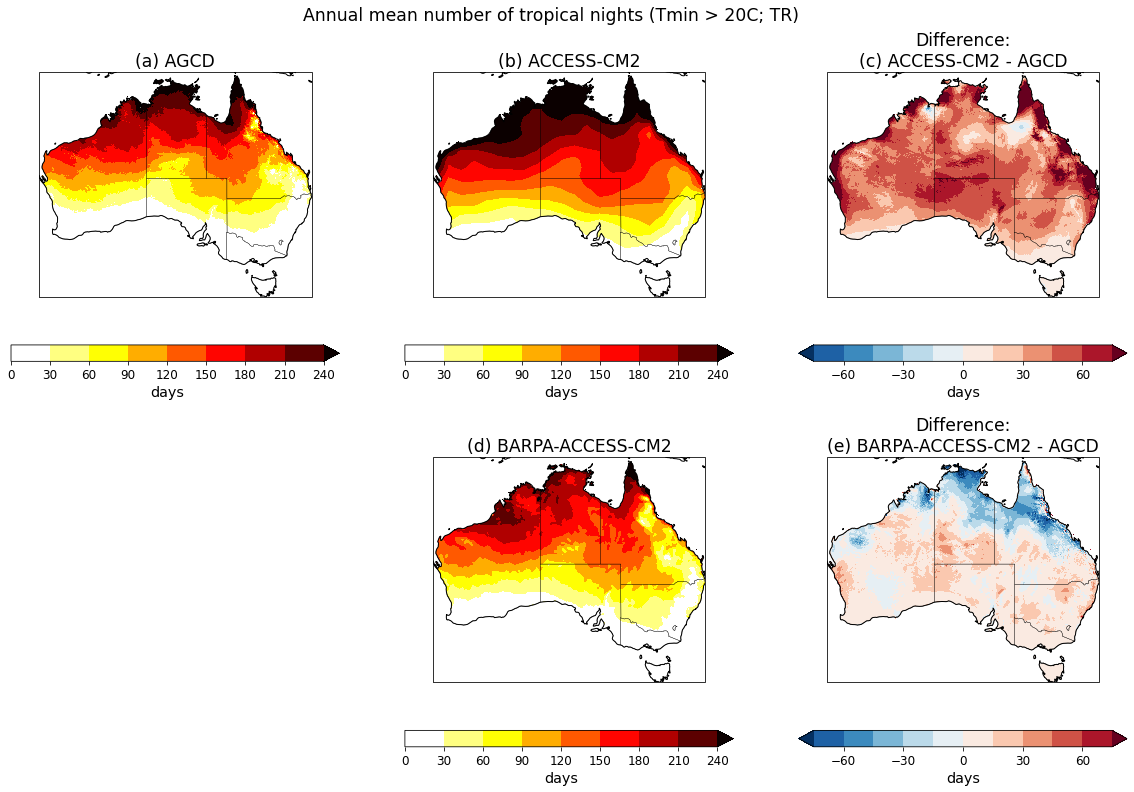

In [19]:
plot_index(
    'tasmin',
    'TR',
    [0, 30, 60, 90, 120, 150, 180, 210, 240],
    [-75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75],
    '/g/data/xv83/dbi599/indices/tr_year_AGCD_v1_r005_1910-2021.nc',
    '/g/data/xv83/dbi599/indices/tr_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc',
    '/g/data/xv83/dbi599/indices/tr_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_gn_1980-1989.nc',
)